In [1]:
# import sys
# import gymnasium as gym
# sys.modules["gym"] = gym
import gym
gym.__version__

'0.21.0'

In [2]:
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from math import remainder, tau
from scipy.spatial import distance

In [4]:
import gnwrapper

In [5]:
env_id = "CarRacing-v0"
NUM_CPU = 32  # Number0of processes to use

Track generation: 1236..1549 -> 313-tiles track
(312, 4)
[[ 0.0158349   0.03138576  0.04693662  0.06248748]
 [ 3.49996475  6.9999302  10.49989565 13.99986111]]
[0.00452427 0.00448369 0.00447017 0.00446341]


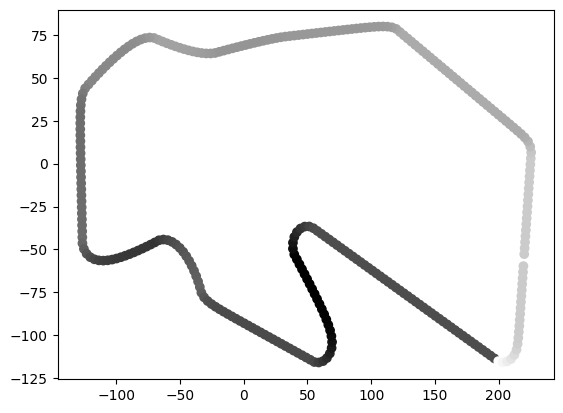

In [7]:
env = gym.make(env_id) 
env.reset()
try:
    track = np.array(env.track)
    print(track.shape)
    # plt.plot(track[:, 2], track[:, 3])
    plt.scatter(track[:, 2], track[:, 3], c=-track[:, 1], cmap='gray')
    car_position =  env.car.hull.position
    car_angle = -env.car.hull.angle
    
    rot = np.array([[np.cos(car_angle), -np.sin(car_angle)], [np.sin(car_angle), np.cos(car_angle)]])
    arg = np.argmin(distance.cdist([car_position], track[:, 2:4]))
    track_size = track.shape[0]
    path = rot @ (track[arg+1-track_size:arg+5-track_size:1, 2:4] - car_position).T
    
    print(path)
    path_angles = np.arctan2(*path)
    print(path_angles)
except Exception as e:
    print('ERROR', e)
env.close()

In [8]:
from scipy.spatial import distance
class CarRacingGroundTruthObsWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.low_state = np.array(
            [0, -np.pi, *[-float('inf'), -float('inf'), -np.pi]*4], dtype=np.float32
        )
        self.high_state = np.array(
            [100, np.pi, *[float('inf'), float('inf'), np.pi]*4], dtype=np.float32
        )
        self.observation_space = gym.spaces.Box(
            low=self.low_state, high=self.high_state, dtype=np.float32
        )
        
    def observation(self, obs):
        velocity = np.sqrt(
            np.square(self.car.hull.linearVelocity[0])
            + np.square(self.car.hull.linearVelocity[1])
        )
        angular_velocity = self.car.hull.angularVelocity
        # ABS sensors
        # abs_sensors = []
        # for i in range(4):
            # abs_sensors.append(0.01 * self.car.wheels[i].omega)
        car_position =  self.car.hull.position
        car_angle = -self.car.hull.angle
        track = np.array(self.track)
        
        rot = np.array([[np.cos(car_angle), -np.sin(car_angle)], [np.sin(car_angle), np.cos(car_angle)]])
        arg = np.argmin(distance.cdist([car_position], track[:, 2:4]))
        track_size = track.shape[0]
        path = rot @ (track[arg+1-track_size:arg+5-track_size:1, 2:4] - car_position).T
        path_angles = np.expand_dims(np.arctan2(*path), axis=0)
        
        # print(path.shape, path_angles.shape)
        # print(np.concatenate((path.T, path_angles.T), axis=1))
        # print()
        # print(path_angles)
        return np.array([velocity, angular_velocity, *np.concatenate((path, path_angles), axis=0).ravel(order='F')])


In [9]:
# env = gym.make(env_id)
# env = CarRacingGroundTruthObsWrapper(env)
# env = SubprocVecEnv([env]*NUM_CPU)
# env = DummyVecEnv([lambda: CarRacingGroundTruthObsWrapper(gym.make(env_id))])
env = make_vec_env(env_id, n_envs=NUM_CPU, wrapper_class=CarRacingGroundTruthObsWrapper)
env.observation_space

Box([ 0.        -3.1415927       -inf       -inf -3.1415927       -inf
       -inf -3.1415927       -inf       -inf -3.1415927       -inf
       -inf -3.1415927], [100.          3.1415927         inf         inf   3.1415927         inf
         inf   3.1415927         inf         inf   3.1415927         inf
         inf   3.1415927], (14,), float32)

In [10]:
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100_000, progress_bar=True)

env.close()

Using cuda device
Track generation: 1115..1406 -> 291-tiles track
Track generation: 834..1053 -> 219-tiles track
Track generation: 1242..1563 -> 321-tiles track
Track generation: 1248..1564 -> 316-tiles track
Track generation: 1118..1408 -> 290-tiles track
Track generation: 1111..1393 -> 282-tiles track
Track generation: 1207..1513 -> 306-tiles track
Track generation: 1052..1325 -> 273-tiles track
Track generation: 1157..1450 -> 293-tiles track
Track generation: 1082..1362 -> 280-tiles track
Track generation: 1030..1299 -> 269-tiles track
Track generation: 1143..1433 -> 290-tiles track
Track generation: 1271..1593 -> 322-tiles track
Track generation: 1163..1458 -> 295-tiles track
Track generation: 1115..1407 -> 292-tiles track
Track generation: 1160..1454 -> 294-tiles track
Track generation: 1187..1488 -> 301-tiles track
Track generation: 1199..1503 -> 304-tiles track
Track generation: 1023..1286 -> 263-tiles track
retry to generate track (normal if there are not manyinstances of this 

Output()

Track generation: 1420..1779 -> 359-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,936/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1217..1533 -> 316-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,936/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1122..1407 -> 285-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 992..1244 -> 252-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1186..1487 -> 301-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 948..1189 -> 241-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1100..1379 -> 279-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1113..1396 -> 283-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1250..1567 -> 317-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1092..1369 -> 277-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1379..1728 -> 349-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1112..1394 -> 282-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1244..1559 -> 315-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1210..1516 -> 306-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1030..1291 -> 261-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1073..1353 -> 280-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1143..1433 -> 290-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1111..1393 -> 282-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1198..1502 -> 304-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:19 < 0:04:49 , 236 it/s ]

Track generation: 1106..1387 -> 281-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:20 < 0:04:49 , 236 it/s ]

Track generation: 1087..1363 -> 276-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:20 < 0:04:49 , 236 it/s ]

Track generation: 1143..1433 -> 290-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:20 < 0:04:49 , 236 it/s ]

Track generation: 1100..1383 -> 283-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:20 < 0:04:49 , 236 it/s ]

retry to generate track (normal if there are not manyinstances of this message)
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:20 < 0:04:49 , 236 it/s ]

Track generation: 1340..1679 -> 339-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:20 < 0:04:49 , 236 it/s ]

Track generation: 1091..1368 -> 277-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:20 < 0:04:49 , 236 it/s ]

Track generation: 1261..1580 -> 319-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:20 < 0:04:49 , 236 it/s ]

Track generation: 1184..1484 -> 300-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:20 < 0:04:49 , 236 it/s ]

Track generation: 1173..1470 -> 297-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:20 < 0:04:49 , 236 it/s ]

Track generation: 983..1233 -> 250-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:20 < 0:04:49 , 236 it/s ]

Track generation: 1066..1336 -> 270-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:20 < 0:04:49 , 236 it/s ]

Track generation: 1065..1335 -> 270-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:20 < 0:04:49 , 236 it/s ]

Track generation: 1133..1420 -> 287-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:20 < 0:04:49 , 236 it/s ]

Track generation: 934..1177 -> 243-tiles track
  32% ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31,968/100,000  [ 0:02:20 < 0:04:49 , 236 it/s ]

Track generation: 1032..1294 -> 262-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,936/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

Track generation: 1087..1362 -> 275-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,936/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

Track generation: 1259..1585 -> 326-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,936/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

Track generation: 1080..1363 -> 283-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,936/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

Track generation: 1096..1374 -> 278-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,936/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

Track generation: 1207..1513 -> 306-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

Track generation: 1034..1299 -> 265-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

retry to generate track (normal if there are not manyinstances of this message)
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

Track generation: 1147..1438 -> 291-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

Track generation: 1267..1588 -> 321-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

Track generation: 1152..1444 -> 292-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

Track generation: 1181..1480 -> 299-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

Track generation: 1020..1279 -> 259-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

Track generation: 1041..1307 -> 266-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

retry to generate track (normal if there are not manyinstances of this message)
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

Track generation: 1221..1530 -> 309-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

Track generation: 1190..1490 -> 300-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

Track generation: 1262..1581 -> 319-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:36 < 0:02:34 , 234 it/s ]

Track generation: 1147..1438 -> 291-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1215..1523 -> 308-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1247..1563 -> 316-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1163..1458 -> 295-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1216..1524 -> 308-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1336..1674 -> 338-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1180..1479 -> 299-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1088..1364 -> 276-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1061..1330 -> 269-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1063..1333 -> 270-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1199..1503 -> 304-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1139..1428 -> 289-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1171..1467 -> 296-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1040..1304 -> 264-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1112..1394 -> 282-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1151..1443 -> 292-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1172..1469 -> 297-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

Track generation: 1151..1451 -> 300-tiles track
  64% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 63,968/100,000  [ 0:04:37 < 0:02:34 , 234 it/s ]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -54.8    |
| time/              |          |
|    fps             | 228      |
|    iterations      | 1        |
|    time_elapsed    | 286      |
|    total_timesteps | 65536    |
---------------------------------


Track generation: 1049..1317 -> 268-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,936/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1276..1599 -> 323-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,936/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 983..1233 -> 250-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,936/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 972..1219 -> 247-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,936/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1113..1395 -> 282-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1079..1353 -> 274-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1164..1459 -> 295-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1153..1446 -> 293-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1279..1603 -> 324-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1088..1364 -> 276-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1152..1448 -> 296-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

retry to generate track (normal if there are not manyinstances of this message)
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1181..1480 -> 299-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1115..1398 -> 283-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1181..1484 -> 303-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1214..1522 -> 308-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1261..1580 -> 319-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1100..1388 -> 288-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1213..1528 -> 315-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1037..1305 -> 268-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1176..1474 -> 298-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1184..1484 -> 300-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1336..1674 -> 338-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1077..1350 -> 273-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1030..1294 -> 264-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

retry to generate track (normal if there are not manyinstances of this message)
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1155..1449 -> 294-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1046..1317 -> 271-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:38 < 0:00:18 , 230 it/s ]

Track generation: 1060..1329 -> 269-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:39 < 0:00:18 , 230 it/s ]

Track generation: 1143..1433 -> 290-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:39 < 0:00:18 , 230 it/s ]

Track generation: 1200..1504 -> 304-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:39 < 0:00:18 , 230 it/s ]

Track generation: 1152..1444 -> 292-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:39 < 0:00:18 , 230 it/s ]

Track generation: 1068..1347 -> 279-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:39 < 0:00:18 , 230 it/s ]

Track generation: 1183..1483 -> 300-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:39 < 0:00:18 , 230 it/s ]

Track generation: 1212..1519 -> 307-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:39 < 0:00:18 , 230 it/s ]

Track generation: 1366..1711 -> 345-tiles track
  96% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 95,968/100,000  [ 0:07:39 < 0:00:18 , 230 it/s ]

Track generation: 1287..1613 -> 326-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,936/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1195..1498 -> 303-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,936/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1196..1499 -> 303-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,936/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1121..1405 -> 284-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1106..1395 -> 289-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1147..1438 -> 291-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1262..1590 -> 328-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1194..1497 -> 303-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1192..1494 -> 302-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1204..1509 -> 305-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1199..1503 -> 304-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1230..1542 -> 312-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1207..1518 -> 311-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1183..1487 -> 304-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1126..1418 -> 292-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1087..1363 -> 276-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1192..1494 -> 302-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1160..1454 -> 294-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1285..1610 -> 325-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1148..1439 -> 291-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1053..1329 -> 276-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1250..1566 -> 316-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1191..1492 -> 301-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1235..1548 -> 313-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1244..1559 -> 315-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1152..1444 -> 292-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1019..1284 -> 265-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1206..1515 -> 309-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

retry to generate track (normal if there are not manyinstances of this message)
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1106..1386 -> 280-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1177..1480 -> 303-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1164..1468 -> 304-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 975..1228 -> 253-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

Track generation: 1049..1315 -> 266-tiles track
 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127,968/100,000  [ 0:07:56 < 0:00:00 , 233 it/s ]

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1e+03        |
|    ep_rew_mean          | -50.8        |
| time/                   |              |
|    fps                  | 207          |
|    iterations           | 2            |
|    time_elapsed         | 630          |
|    total_timesteps      | 131072       |
| train/                  |              |
|    approx_kl            | 0.0066342466 |
|    clip_fraction        | 0.0685       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.23        |
|    explained_variance   | 0.00374      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0752       |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00448     |
|    std                  | 0.99         |
|    value_loss           | 0.41         |
------------------------------------------


In [16]:
env = gym.make(env_id)
env = CarRacingGroundTruthObsWrapper(env)
env
# obs = env.reset()
# while True:
#     action, _states = model.predict(obs)
#     obs, rewards, dones, info = env.step(action)
#     env.render()
#     if dones:
#         break
    
# env.close()

<CarRacingGroundTruthObsWrapper<TimeLimit<CarRacing<CarRacing-v0>>>>

In [13]:
env.close()

In [ ]:
env = DummyVecEnv([lambda: CarRacingGroundTruthObsWrapper(gym.make(env_id))])
# env = gnwrapper.Animation(env)

# env = DummyVecEnv([lambda: env])
obs = env.reset()
for _ in range(10000):
    action, _states = model.predict(obs)
    # action = np.array([0.1, 0.01, 0])
    obs, rewards, dones, info = env.step(action)
    env.render()